# Preparation
## Importing necessary datasets and libraries

In [1]:
# Stops the verbose form PyMC
import logging
logger = logging.getLogger("pymc")
logger.propagate = False
logger.setLevel(logging.ERROR)

from base_functions import *
test_script()

Script containing strategy evaluation functions were imported successfully!


In [2]:
# Imports df
try:
    df = pd.read_csv('odds_df.csv')
except:
    csv_url = "https://www.football-data.co.uk/new/BRA.csv"
    df = pd.read_csv(csv_url)


# Isolates the period under analysis and filter columns
df = df[(df['Season'] >= 2019) & (df['Season'] <= 2024)]
columns_to_keep = ['Season', 'Home', 'Away', 'HG', 'AG', 'Res', 'AvgCH', 'AvgCD', 'AvgCA','MaxCH', 'MaxCD', 'MaxCA', 'PSCH', 'PSCD', 'PSCA']
df = df[columns_to_keep]
df = df.dropna(subset=columns_to_keep)

df.head()

,Season,Home,Away,HG,AG,Res,AvgCH,AvgCD,AvgCA,MaxCH,MaxCD,MaxCA,PSCH,PSCD,PSCA
2660,2019,Sao Paulo,Botafogo RJ,2.0,0.0,H,1.74,3.37,5.14,1.81,3.60,5.80,1.78,3.39,5.61
2661,2019,Atletico-MG,Avai,2.0,1.0,H,1.53,3.90,6.34,1.58,4.09,7.00,1.56,4.09,6.46
2662,2019,Chapecoense-SC,Internacional,2.0,0.0,H,2.94,2.94,2.59,3.15,3.20,2.71,3.02,3.03,2.71
2663,2019,Flamengo RJ,Cruzeiro,3.0,1.0,H,2.21,3.12,3.40,2.32,3.40,3.57,2.32,3.20,3.47
2664,2019,Gremio,Santos,1.0,2.0,A,1.71,3.41,5.31,1.83,3.60,5.94,1.71,3.58,5.78


# Always following the leaderboard

Here, we place a bet in every match on the team ranked the highest. Our main assumptions are:
1. The bookmaker's vig is evenly spread across outcomes, allowing us to derive the odds-implied probablities through the multiplication method
2. We have no reason to believe that the predictive capacity of rankings changes over time. Therefore, the sharpness of this strategy should remain the same across seasons, which means a complete pooling approach when estimating sharpness.

The CBF's (Brazilian Confederation of Football) ranking follows a traditional pointing system: in a match, the winning team gets three points and the losing team gets zero. In case of a draw, both teams get one pont. In case of a tie in points, the ranking is untied by number of victories and goal difference in the season, respectively.

Source: https://ge.globo.com/futebol/reportagem/2024/04/10/c-como-funciona-o-campeonato-brasileiro-veja-tudo-sobre-a-competicao.ghtml

In [3]:
def update_leaderboard(leaderboard, row):
  '''
  Updates the leaderboard of teams following the conventions
  of the Brazilian soccer championship
  '''
  # Isolates variables from the given row of the dataframe
  home_team = row['Home']
  away_team = row['Away']
  home_goals = row['HG']
  away_goals = row['AG']

  if row['Res'] == 'H': # Home win
    leaderboard[home_team]['points'] += 3
    leaderboard[home_team]['victories'] += 1
    leaderboard[home_team]['gd'] += home_goals - away_goals
    leaderboard[away_team]['gd'] += away_goals - home_goals
  elif row['Res'] == 'A':  # Away win
    leaderboard[away_team]['points'] += 3
    leaderboard[away_team]['victories'] += 1
    leaderboard[away_team]['gd'] += away_goals - home_goals
    leaderboard[home_team]['gd'] += home_goals - away_goals
  elif row['Res'] == 'D':  # Draw
    leaderboard[home_team]['points'] += 1
    leaderboard[away_team]['points'] += 1
    leaderboard[home_team]['gd'] += home_goals - away_goals
    leaderboard[away_team]['gd'] += away_goals - home_goals

def check_best_standing_team(leaderboard, row):
  '''
  Determines, according to the leaderboard, which team is the favorite in a match
  '''
  # Isolates teams
  home_team = row['Home']
  away_team = row['Away']

  # Extract stats for both teams
  home_stats = leaderboard[home_team]
  away_stats = leaderboard[away_team]

  # Compare primary factor: points
  if home_stats['points'] > away_stats['points']:
      return 'H'
  elif home_stats['points'] < away_stats['points']:
      return 'A'

  # Compare secondary factor: victories
  if home_stats['victories'] > away_stats['victories']:
      return 'H'
  elif home_stats['victories'] < away_stats['victories']:
      return 'A'

  # Compare tertiary factor: goal difference (gd)
  if home_stats['gd'] > away_stats['gd']:
      return 'H'
  elif home_stats['gd'] < away_stats['gd']:
      return 'A'

  return 'H' # If all factors are tied, return 'H' by default (arbitrary decision)

def run_leaderboard_bet(df, seasons, plot_title, home_constraint = False, odds_picking = False):
  '''
  Backtests strategy of always betting $1 on the team with the
  best placement in the leaderboard.

  This code allows us to test two variants of this stragey: 1) always betting on the
  best ranked team and 2) always betting on the best ranked team only when it plays at home

  NOTE: We skip the first 5 rounds of the tournament as we consider this to be
  an adjustment period before the leaderboard is reliable
  '''

  # Initializes lists to store results for each season
  betting_log = pd.DataFrame(columns=['Season', 'Target', 'Result', 'Successful bet', 'Profit/Loss', 'Odds locked', 'Pinnacle OIP'])

  for season in seasons:
    # Prepares dataframe and ranking
    season_df = df[df['Season'] == season].copy().reset_index(drop=True)
    season_df['Round'] = (season_df.index // 10)
    leaderboard = {team: {'points': 0, 'victories': 0, 'gd': 0} for team in season_df['Home'].unique()}

    for index, row in season_df.iterrows():
      # When only betting on home favorites, this variable informs the code whether a bet should be skipped for not meeting the criteria
      no_bet = False

      # If still at the beginning of a season, place no bets and just update leaderboard
      if row['Round'] < 5:
        update_leaderboard(leaderboard, row)

      else:
        target = check_best_standing_team(leaderboard, row) # Our bet target is the best-ranked team in each match

        if (home_constraint == True) and (target != 'H'):
            no_bet = True # Informs that we should not bet if best-ranked team is not playing at home when that rule is enforced

        if no_bet == False:
          result = row['Res']
          successful_bet = 1 if target == result else 0
          odds_locked = row[f'MaxC{target}'] if odds_picking else row[f'AvgC{target}']
          profit_loss = (odds_locked - 1) if successful_bet else -1
          pinnacle_odds_implied_probability = (1/row[f'PSC{target}']) / ( (1/row['PSCH']) + (1/row['PSCD']) + (1/row['PSCA']) )

          # Populates betting log with info specific to each match
          betting_log.loc[len(betting_log)] = {'Season': season,
                                            'Target': target,
                                            'Result': result,
                                            'Successful bet': successful_bet,
                                            'Profit/Loss': profit_loss,
                                            'Odds locked': odds_locked,
                                            'Pinnacle OIP': pinnacle_odds_implied_probability}


        # Update leaderboard and bankroll after game, regardless of whether we placed a bet or not
        update_leaderboard(leaderboard, row)

  # Runs analysis of results and isolates posterior
  posterior_samples = summarize_results(seasons, betting_log, plot_title)
  return posterior_samples

**Conclusion:**

Blindly betting on the team with the best standing does not give us any edge. In terms of sharpness, we perform just as well as the baseline of always betting on the home team (between 42%-47% of success for standings, compared to 44%-48% of baseline). In terms of profit, both methods perform similarly, with an expectation of -0.61% for the ranking-based strategy versus -0.17% for the baseline. The Monte Carlo simulations also tell us that, by following the standings, we have a 58.9% chance of ending with a loss, which is not good news, given our backtests already assume the bettor can find optimal odds at every match by looking through many bookmakers. If this strategy were to be run by a bettor with a weaker ability to find optimal odds, or a bettor who consistently bets with odds that are on average for the market, the results are worse: the probability of ending with a loss jumps from 58.9% to 98.3%

We can observe an improvement if we add the additional constrait of only placing bets if our chosen team plays at home. The sharpness credible intervals have a statistically significant different, changing from [0.43, 0.47] to [0.52, 0.59]. Yet, we are financially left in the same place as before, which means the bookmakers are already account for this difference in their pricing too. (The code showing this is below).

Betting on Best Standing Team
Season-specific results
╒══════════╤═══════════════╤═══════════════════╤════════════════╤══════════════════╤════════╤══════════════╕
│  Season  │  Bets Placed  │  Successful Bets  │  Sharpness CI  │  Sharpness Mean  │  RBEP  │  Profit (%)  │
╞══════════╪═══════════════╪═══════════════════╪════════════════╪══════════════════╪════════╪══════════════╡
│   2019   │      330      │        161        │ [0.433, 0.54]  │       0.49       │  0.47  │     2.47     │
├──────────┼───────────────┼───────────────────┼────────────────┼──────────────────┼────────┼──────────────┤
│   2020   │      330      │        145        │ [0.389, 0.493] │       0.44       │  0.45  │    -5.67     │
├──────────┼───────────────┼───────────────────┼────────────────┼──────────────────┼────────┼──────────────┤
│   2021   │      330      │        136        │ [0.36, 0.467]  │       0.41       │  0.42  │    -7.74     │
├──────────┼───────────────┼───────────────────┼────────────────┼─────────

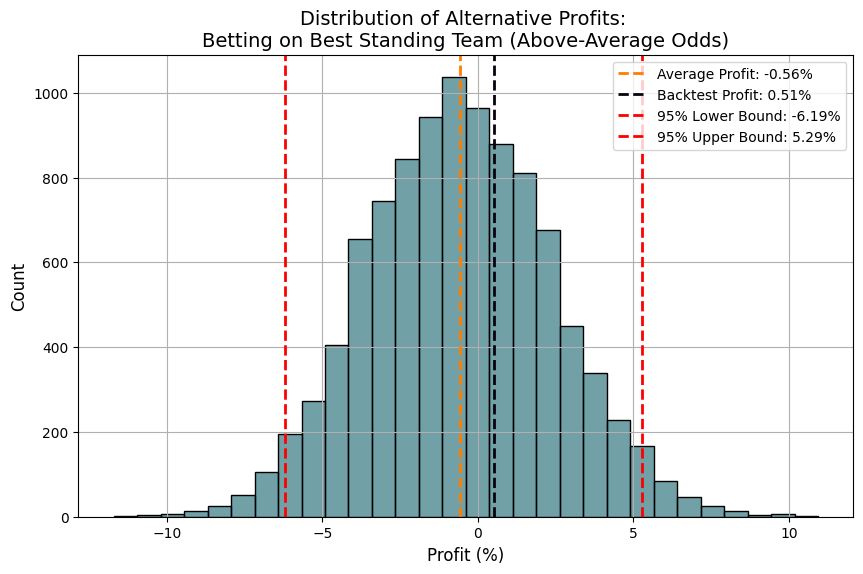


Summary of random effect analysis
  Average profit over simulations: -0.56%
  95% interval of profit: [-6.19%, 5.29%]
  Probability of ending better off than in the backtest: 35.71%
  Probability of ending with a loss: 57.94%

Betting on Best Standing Team (Home Constraint)
Season-specific results
╒══════════╤═══════════════╤═══════════════════╤════════════════╤══════════════════╤════════╤══════════════╕
│  Season  │  Bets Placed  │  Successful Bets  │  Sharpness CI  │  Sharpness Mean  │  RBEP  │  Profit (%)  │
╞══════════╪═══════════════╪═══════════════════╪════════════════╪══════════════════╪════════╪══════════════╡
│   2019   │      165      │        100        │ [0.533, 0.681] │       0.6        │  0.61  │     2.48     │
├──────────┼───────────────┼───────────────────┼────────────────┼──────────────────┼────────┼──────────────┤
│   2020   │      169      │        90         │ [0.456, 0.604] │       0.53       │  0.52  │     1.03     │
├──────────┼───────────────┼──────────────────

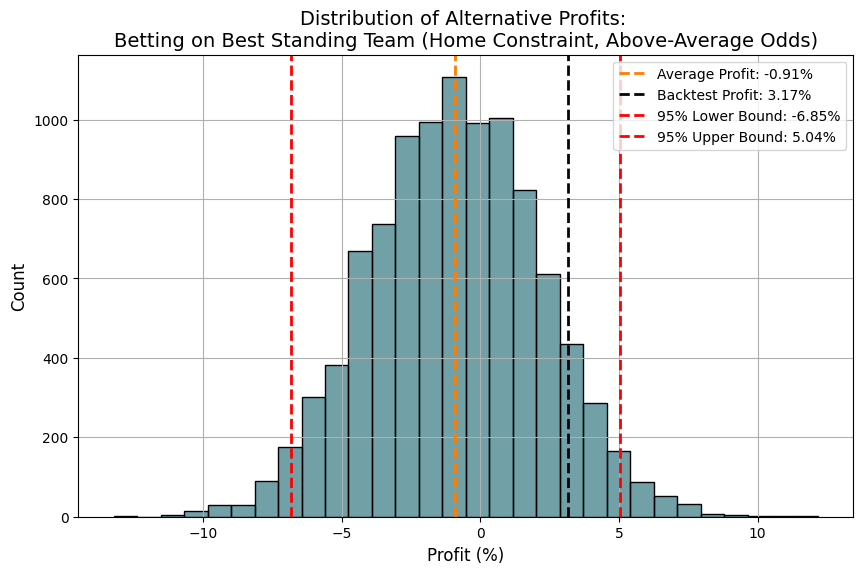


Summary of random effect analysis
  Average profit over simulations: -0.91%
  95% interval of profit: [-6.85%, 5.04%]
  Probability of ending better off than in the backtest: 8.87%
  Probability of ending with a loss: 61.10%


In [72]:
seasons = [2019, 2020, 2021, 2022, 2023, 2024]

print('Betting on Best Standing Team')
posterior_leaderboard_default = run_leaderboard_bet(df, seasons, '\nBetting on Best Standing Team (Above-Average Odds)', home_constraint = False, odds_picking = True)

print('\nBetting on Best Standing Team (Home Constraint)')
_ = run_leaderboard_bet(df, seasons, '\nBetting on Best Standing Team (Home Constraint, Above-Average Odds)', home_constraint = True, odds_picking = True)

Betting on Best Standing Team
Season-specific results
╒══════════╤═══════════════╤═══════════════════╤════════════════╤══════════════════╤════════╤══════════════╕
│  Season  │  Bets Placed  │  Successful Bets  │  Sharpness CI  │  Sharpness Mean  │  RBEP  │  Profit (%)  │
╞══════════╪═══════════════╪═══════════════════╪════════════════╪══════════════════╪════════╪══════════════╡
│   2019   │      330      │        161        │ [0.434, 0.54]  │       0.49       │  0.49  │    -2.93     │
├──────────┼───────────────┼───────────────────┼────────────────┼──────────────────┼────────┼──────────────┤
│   2020   │      330      │        145        │ [0.386, 0.495] │       0.44       │  0.47  │    -10.23    │
├──────────┼───────────────┼───────────────────┼────────────────┼──────────────────┼────────┼──────────────┤
│   2021   │      330      │        136        │ [0.359, 0.464] │       0.41       │  0.44  │    -12.7     │
├──────────┼───────────────┼───────────────────┼────────────────┼─────────

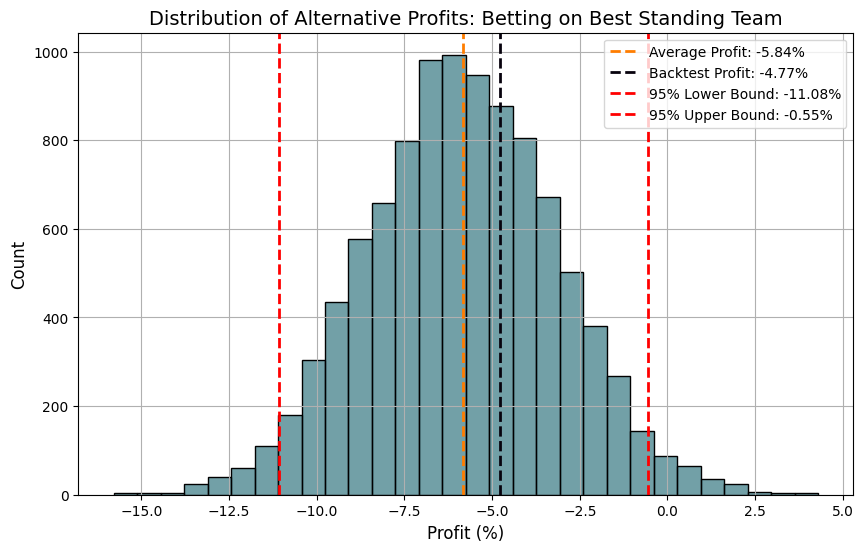


Summary of random effect analysis
  Average profit over simulations: -5.84%
  95% interval of profit: [-11.08%, -0.55%]
  Probability of ending better off than in the backtest: 34.72%
  Probability of ending with a loss: 98.31%

Betting on Best Standing Team (Home Constraint)
Season-specific results
╒══════════╤═══════════════╤═══════════════════╤════════════════╤══════════════════╤════════╤══════════════╕
│  Season  │  Bets Placed  │  Successful Bets  │  Sharpness CI  │  Sharpness Mean  │  RBEP  │  Profit (%)  │
╞══════════╪═══════════════╪═══════════════════╪════════════════╪══════════════════╪════════╪══════════════╡
│   2019   │      165      │        100        │ [0.529, 0.677] │       0.6        │  0.63  │    -1.48     │
├──────────┼───────────────┼───────────────────┼────────────────┼──────────────────┼────────┼──────────────┤
│   2020   │      169      │        90         │ [0.458, 0.608] │       0.53       │  0.55  │    -3.28     │
├──────────┼───────────────┼────────────────

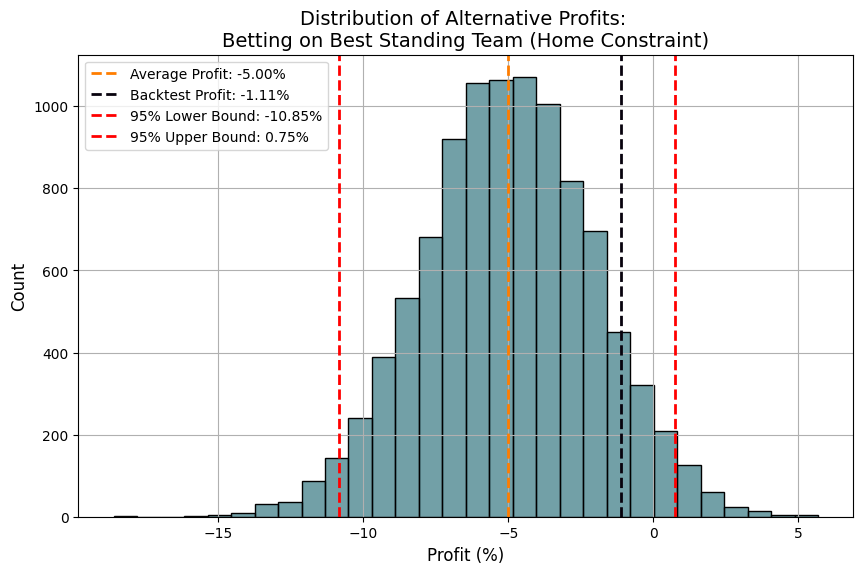


Summary of random effect analysis
  Average profit over simulations: -5.00%
  95% interval of profit: [-10.85%, 0.75%]
  Probability of ending better off than in the backtest: 9.24%
  Probability of ending with a loss: 95.52%


In [10]:
# Simulations demonstrating what happens to a bettor who is not capable of finding above-average odds
print('Betting on Best Standing Team')
_ = run_leaderboard_bet(df, seasons, '\nBetting on Best Standing Team (Average Odds)', home_constraint = False)

print('\nBetting on Best Standing Team (Home Constraint)')
_ = run_leaderboard_bet(df, seasons, '\nBetting on Best Standing Team (Home Constraint, Average Odds)', home_constraint = True)

# Leaderboard bet: top (x) vs bottom (y) teams (with and without the constraint of the top team playing at home)

Now, using rankings to measure the quality of teams and predict a winner might not be entirely bad. So far, we are betting in all matches, which means that any ranking difference is taken into account. However, the reader might agree that the difference in quality between the teams ranked 17th and 18th are likely negligible. On the other hand, the difference in quality between the teams ranked 2nd and 19th is likely massive. This is why we created a second version of the strategy which focused more on gaps in rankings to see how it performs. 

Here, we will only place a bet if one of the best X teams is playing against one of the worst Y teams, modifying the parameters X and Y to see how this affects results.

We also try a modification of this method, adding another constraint that the top X teams must play at home, and contrast both results.

In [4]:
# Updated version 
def check_criteria(leaderboard, row, x, y, home_constraint = False):
    '''
    This function checks whether a given match has one of the top X teams
    playing against one of the bottom Y teams
    '''
    # Step 1: Extract the teams
    home_team = row['Home']
    away_team = row['Away']
    # Step 2: Sort the leaderboard by points, victories, and gd
    sorted_leaderboard = sorted(
        leaderboard.items(),
        key=lambda item: (item[1]['points'], item[1]['victories'], item[1]['gd']),
        reverse=True
    )

    # Step 3: Extract the team names for the top X and bottom Y
    top_teams = [team for team, _ in sorted_leaderboard[:x]]
    bottom_teams = [team for team, _ in sorted_leaderboard[-y:]]

    # Step 4: Check the constraint at hand: 
    # Option 1: one of the teams being in the top X and the other in the bottom Y
    # Option 2: one of the teams being in the top X and playing at home while the other in the bottom Y
    if home_constraint == False:
        if (home_team in top_teams and away_team in bottom_teams) or (away_team in top_teams and home_team in bottom_teams):
            return True
    else: 
        if (home_team in top_teams and away_team in bottom_teams):
            return True
    return False

def run_constrained_leaderboard_bet(df, seasons, top_x, bottom_y, plot_title, analysis_type = "Full", home_constraint = False, odds_picking = False):
  '''
  Backtests strategy of always betting $1 on the team with the best placement in the leaderboard.

  This code allows us to test two variants of this stragey: 1) always betting on the
  best ranked team and 2) always betting on the best ranked team only when it plays at home

  NOTE: We skip the first 5 rounds of the tournament as we consider this to be
  an adjustment period before the leaderboard is reliable
  '''

  # Initializes lists to store results for each season
  betting_log = pd.DataFrame(columns=['Season', 'Target', 'Result', 'Successful bet', 'Profit/Loss', 'Odds locked', 'Pinnacle OIP'])

  for season in seasons:
    # Prepares dataframe and ranking
    season_df = df[df['Season'] == season].copy().reset_index(drop=True)
    season_df['Round'] = (season_df.index // 10)
    leaderboard = {team: {'points': 0, 'victories': 0, 'gd': 0} for team in season_df['Home'].unique()}

    for index, row in season_df.iterrows():
      # When only betting on home favorites, this variable informs the code whether a bet should be skipped for not meeting the criteria
      no_bet = False

      # If still at the beginning of a season, place no bets and just update leaderboard
      if (row['Round'] < 5) or (check_criteria(leaderboard, row, top_x, bottom_y, home_constraint) == False):
        update_leaderboard(leaderboard, row)

      else:
        target = check_best_standing_team(leaderboard, row) # Our bet target is the best-ranked team in each match
        result = row['Res']
        successful_bet = 1 if target == result else 0
        odds_locked = row[f'MaxC{target}'] if odds_picking else row[f'AvgC{target}']
        profit_loss = (odds_locked - 1) if successful_bet else -1
        pinnacle_odds_implied_probability = (1/row[f'PSC{target}']) / ( (1/row['PSCH']) + (1/row['PSCD']) + (1/row['PSCA']) )

        # Populates betting log with info specific to each match
        betting_log.loc[len(betting_log)] = {'Season': season,
                                          'Target': target,
                                          'Result': result,
                                          'Successful bet': successful_bet,
                                          'Profit/Loss': profit_loss,
                                          'Odds locked': odds_locked,
                                          'Pinnacle OIP': pinnacle_odds_implied_probability}


        # Update leaderboard and bankroll after game, regardless of whether we placed a bet or not
        update_leaderboard(leaderboard, row)

  # Runs analysis of results and isolates posterior
  if analysis_type == 'Full':
    posterior_samples = summarize_results(seasons, betting_log, plot_title)
  elif analysis_type == 'Seasonal':
     print('Season-specific results')
     summarize_season_results(seasons, betting_log)
     print('\nOverall results')
     posterior_samples = summarize_complete_results(betting_log)
  elif analysis_type == 'Summary':
    posterior_samples = summarize_complete_results(betting_log)
  
  return posterior_samples

## Sharpness evaluation

In [19]:
# Standard reasoning: top team against bottom teams
print('REASONING: Simply betting on the 10 best teams against the 10 worst\n\n')
print('Regular Top 10 vs. Bottom 10')
_ = run_constrained_leaderboard_bet(df, seasons, top_x = 10, bottom_y = 10, plot_title = "Top 10 vs. Bottom 10", analysis_type = 'Summary', home_constraint = False, odds_picking = True)
print('\nTop 10 vs. Bottom 10 when Top plays at home')
_ = run_constrained_leaderboard_bet(df, seasons, top_x = 10, bottom_y = 10, plot_title = "Top 10 vs. Bottom 10", analysis_type = 'Summary', home_constraint = True, odds_picking = True)

REASONING: Simply betting on the 10 best teams against the 10 worst


Regular Top 10 vs. Bottom 10
╒══════════════╤═══════════════╤═══════════════════╤════════════════╤══════════════════╤════════╤══════════════╕
│    Season    │  Bets Placed  │  Successful Bets  │  Sharpness CI  │  Sharpness Mean  │  RBEP  │  Profit (%)  │
╞══════════════╪═══════════════╪═══════════════════╪════════════════╪══════════════════╪════════╪══════════════╡
│ Whole period │     1017      │        476        │ [0.437, 0.498] │       0.47       │  0.48  │    -4.24     │
╘══════════════╧═══════════════╧═══════════════════╧════════════════╧══════════════════╧════════╧══════════════╛

Top 10 vs. Bottom 10 when Top plays at home
╒══════════════╤═══════════════╤═══════════════════╤════════════════╤══════════════════╤════════╤══════════════╕
│    Season    │  Bets Placed  │  Successful Bets  │  Sharpness CI  │  Sharpness Mean  │  RBEP  │  Profit (%)  │
╞══════════════╪═══════════════╪═══════════════════╪═════════════

In [21]:
print('REASONING: "The 5 worst teams are losers and might be demoted, so I will bet against them"\n\n')
print('Regular Top 10 vs. Bottom 5')
_ = run_constrained_leaderboard_bet(df, seasons, top_x = 10, bottom_y = 5, plot_title = "Top 10 vs. Bottom 5", analysis_type = 'Summary', home_constraint = False, odds_picking = True)
print('\nTop 10 vs. Bottom 5 when Top plays at home')
_ = run_constrained_leaderboard_bet(df, seasons, top_x = 10, bottom_y = 5, plot_title = "Top 10 vs. Bottom 5 (Home Constraint)", analysis_type = 'Summary', home_constraint = True, odds_picking = True)

REASONING: "The 5 worst teams are losers and might be demoted, so I will bet against them"


Regular Top 10 vs. Bottom 5
╒══════════════╤═══════════════╤═══════════════════╤════════════════╤══════════════════╤════════╤══════════════╕
│    Season    │  Bets Placed  │  Successful Bets  │  Sharpness CI  │  Sharpness Mean  │  RBEP  │  Profit (%)  │
╞══════════════╪═══════════════╪═══════════════════╪════════════════╪══════════════════╪════════╪══════════════╡
│ Whole period │      507      │        257        │ [0.463, 0.549] │       0.51       │  0.5   │     -2.1     │
╘══════════════╧═══════════════╧═══════════════════╧════════════════╧══════════════════╧════════╧══════════════╛

Top 10 vs. Bottom 5 when Top plays at home
╒══════════════╤═══════════════╤═══════════════════╤════════════════╤══════════════════╤════════╤══════════════╕
│    Season    │  Bets Placed  │  Successful Bets  │  Sharpness CI  │  Sharpness Mean  │  RBEP  │  Profit (%)  │
╞══════════════╪═══════════════╪════════════

In [22]:
print('REASONING: The top 5 teams are winners and might even go to intl. tournaments! I am betting on them\n\n')
print('Regular Top 5 vs. Bottom 10')
_ = run_constrained_leaderboard_bet(df, seasons, top_x = 5, bottom_y = 10, plot_title = "Top 5 vs. Bottom 10", analysis_type = 'Summary', home_constraint = False, odds_picking = True)
print('\nTop 5 vs. Bottom 10 when Top plays at home')
_ = run_constrained_leaderboard_bet(df, seasons, top_x = 5, bottom_y = 10, plot_title = "Top 5 vs. Bottom 10 (Home Constraint)", analysis_type = 'Summary', home_constraint = True, odds_picking = True)

REASONING: The top 5 teams are winners and might even go to intl. tournaments! I am betting on them


Regular Top 5 vs. Bottom 10
╒══════════════╤═══════════════╤═══════════════════╤════════════════╤══════════════════╤════════╤══════════════╕
│    Season    │  Bets Placed  │  Successful Bets  │  Sharpness CI  │  Sharpness Mean  │  RBEP  │  Profit (%)  │
╞══════════════╪═══════════════╪═══════════════════╪════════════════╪══════════════════╪════════╪══════════════╡
│ Whole period │      479      │        243        │ [0.463, 0.551] │       0.51       │  0.51  │    -2.55     │
╘══════════════╧═══════════════╧═══════════════════╧════════════════╧══════════════════╧════════╧══════════════╛

Top 5 vs. Bottom 10 when Top plays at home
╒══════════════╤═══════════════╤═══════════════════╤════════════════╤══════════════════╤════════╤══════════════╕
│    Season    │  Bets Placed  │  Successful Bets  │  Sharpness CI  │  Sharpness Mean  │  RBEP  │  Profit (%)  │
╞══════════════╪═══════════════╪═══

In [53]:
print('REASONING: "I have the very best teams playing against the very worst! There is no chance I am losing"\n\n')
print('Regular Top 5 vs. Bottom 5')
posterior_leaderboard_5v5 = run_constrained_leaderboard_bet(df, seasons, top_x = 5, bottom_y = 5, plot_title = "Top 5 vs. Bottom 5", analysis_type = 'Seasonal', home_constraint = False, odds_picking = True)
print('\nTop 5 vs. Bottom 5 when Top plays at home')
posterior_leaderboard_5v5_home = run_constrained_leaderboard_bet(df, seasons, top_x = 5, bottom_y = 5, plot_title = "Top 5 vs. Bottom 5 (Home Constraint)", analysis_type = 'Summary', home_constraint = True, odds_picking = True)

REASONING: "I have the very best teams playing against the very worst! There is no chance I am losing"


Regular Top 5 vs. Bottom 5
Season-specific results
╒══════════╤═══════════════╤═══════════════════╤════════════════╤══════════════════╤════════╤══════════════╕
│  Season  │  Bets Placed  │  Successful Bets  │  Sharpness CI  │  Sharpness Mean  │  RBEP  │  Profit (%)  │
╞══════════╪═══════════════╪═══════════════════╪════════════════╪══════════════════╪════════╪══════════════╡
│   2019   │      42       │        32         │  [0.62, 0.87]  │       0.75       │  0.6   │    24.81     │
├──────────┼───────────────┼───────────────────┼────────────────┼──────────────────┼────────┼──────────────┤
│   2020   │      40       │        21         │ [0.378, 0.674] │       0.52       │  0.61  │    -12.2     │
├──────────┼───────────────┼───────────────────┼────────────────┼──────────────────┼────────┼──────────────┤
│   2021   │      44       │        19         │ [0.288, 0.574] │       0.43     

In [54]:
'''
Evaluates the probability that the sharpness from the constrained version is greater than the sharpness from the
unconstrained version by comparing posterior samples. This gives us a p-value
'''
1 - np.sum(posterior_leaderboard_5v5_home > posterior_leaderboard_5v5)/8000


0.005499999999999949

In [26]:
# Testing with average odds to see if we still profit.
print('REASONING: "I have the very best teams playing against the very worst! There is no chance I am losing"\n\n')
print('Regular Top 5 vs. Bottom 5')
_ = run_constrained_leaderboard_bet(df, seasons, top_x = 5, bottom_y = 5, plot_title = "Top 5 vs. Bottom 5", analysis_type = 'Summary', home_constraint = False, odds_picking = False)
print('\nTop 5 vs. Bottom 5 when Top plays at home')
_ = run_constrained_leaderboard_bet(df, seasons, top_x = 5, bottom_y = 5, plot_title = "Top 5 vs. Bottom 5 (Home Constraint)", analysis_type = 'Summary', home_constraint = True, odds_picking = False)

REASONING: "I have the very best teams playing against the very worst! There is no chance I am losing"


Regular Top 5 vs. Bottom 5
╒══════════════╤═══════════════╤═══════════════════╤════════════════╤══════════════════╤════════╤══════════════╕
│    Season    │  Bets Placed  │  Successful Bets  │  Sharpness CI  │  Sharpness Mean  │  RBEP  │  Profit (%)  │
╞══════════════╪═══════════════╪═══════════════════╪════════════════╪══════════════════╪════════╪══════════════╡
│ Whole period │      241      │        138        │ [0.509, 0.633] │       0.57       │  0.56  │    -0.39     │
╘══════════════╧═══════════════╧═══════════════════╧════════════════╧══════════════════╧════════╧══════════════╛

Top 5 vs. Bottom 5 when Top plays at home
╒══════════════╤═══════════════╤═══════════════════╤════════════════╤══════════════════╤════════╤══════════════╕
│    Season    │  Bets Placed  │  Successful Bets  │  Sharpness CI  │  Sharpness Mean  │  RBEP  │  Profit (%)  │
╞══════════════╪═══════════════╪══

Conclusions:
- We get slightly better results than before when we begin increasing the gap in ranking between the teams, such as only betting on the top 10 against the bottom 5, or even the top 5 against the bottom 5. The larger the gap, the higher the sharpness

- The most interesting finding, however, comes from another simple constraint we can add. Regardless of how we define the thresholds of which top and which bottom teams to bet on, our performance changes meaningfully when we only bet on top teams *who are playing at home*. This naturally reduces the total number of bets we place (in fact, adding the constraint reduces them by nearly half), but it increases the percentage of bets that turn out successful. In all cases, the difference between sharpness levels with and without the home constraint was statistically significant. Even in the case when posterior credible intervals overlap, there is a 99.3% probability that the sharpness from the constrained version is greater than the sharpness from the unconstrained version.

### Plotting sharpness CI
Here we see the difference between the confidence interval of each strategy's sharpness when we leave out and when we include the constraint of only betting on home teams

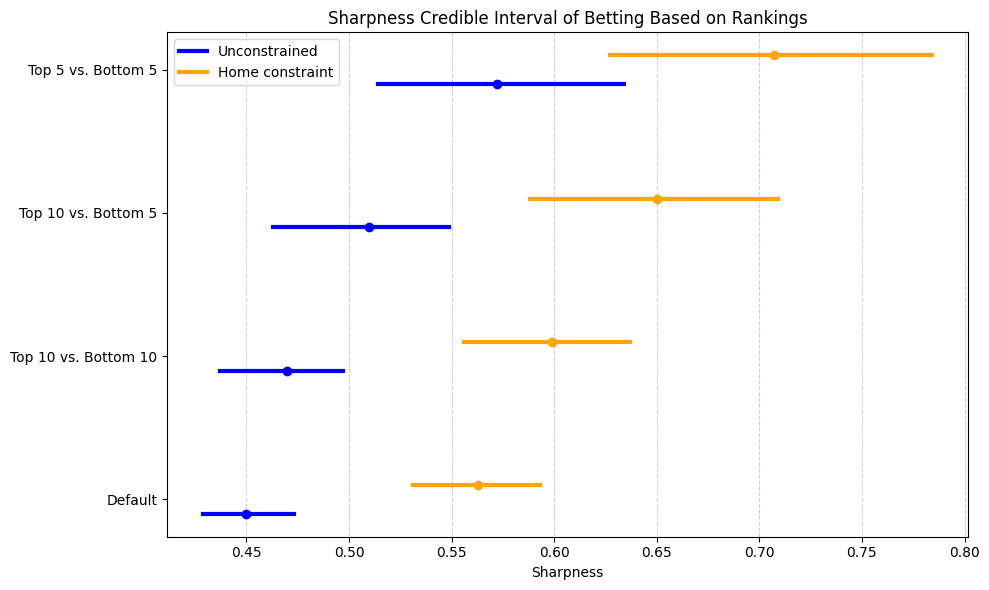

In [55]:
# Data for the new plot
conf_intervals = {
    "Default": [(0.429, 0.473), (0.531, 0.593)],
    "Top 10 vs. Bottom 10": [(0.437, 0.497), (0.556, 0.637)],
    "Top 10 vs. Bottom 5": [(0.463, 0.549), (0.588, 0.709)],
    "Top 5 vs. Bottom 5": [(0.514, 0.634), (0.627, 0.784)]
}

averages = {
    "Default": [0.450, 0.563],
    "Top 10 vs. Bottom 10": [0.47, 0.599],
    "Top 10 vs. Bottom 5": [0.51, 0.650],
    "Top 5 vs. Bottom 5": [0.572, 0.707]
}

# Y-positions for each category
categories = list(conf_intervals.keys())
y_positions = {category: i + 1 for i, category in enumerate(categories)}
day_colors = ["blue", "orange"]  # Blue for Day 1, Orange for Day 2

# Plot setup
fig, ax = plt.subplots(figsize=(10, 6))

# Plot each category's confidence intervals
for category, intervals in conf_intervals.items():
    for idx, (start, end) in enumerate(intervals):
        y = y_positions[category] + (idx - 0.5) * 0.2  # Offset intervals up/down for separation
        avg = averages[category][idx]

        # Plot the confidence interval as a line
        ax.plot([start, end], [y, y], color=day_colors[idx], lw=3, label=f"{['Unconstrained', 'Home constraint'][idx]}" if category == "Default" else None)

        # Plot the average as a point
        ax.plot(avg, y, 'o', color=day_colors[idx])

# Customize plot appearance
ax.set_yticks(list(y_positions.values()))
ax.set_yticklabels(categories)
ax.set_xlabel("Sharpness")
ax.set_title("Sharpness Credible Interval of Betting Based on Rankings")
ax.legend()
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()

# Show the plot
plt.show()


## Profit evaluation

Sharpness is not the only relevant aspect to analyze. We also should look into profit. Our first backtest was carried in somewhat optimistic conditions, assuming a bettor capable of 
looking among different bookmakers to find above-average odds. Under this scenario, five versions of the strategy (out of eight tested) performed well. What happens if we contrast them with and without good odds?

How much do results change if we assume a bettor 

Stress test, making considitions worse

In [34]:
print('\nTop 10 vs. Bottom 10 when Top plays at home: Optimized odds')
_ = run_constrained_leaderboard_bet(df, seasons, top_x = 10, bottom_y = 10, plot_title = "Top 10 vs. Bottom 10", analysis_type = 'Summary', home_constraint = True, odds_picking = True)
print('\nTop 10 vs. Bottom 10 when Top plays at home: Average odds')
_ = run_constrained_leaderboard_bet(df, seasons, top_x = 10, bottom_y = 10, plot_title = "Top 10 vs. Bottom 10", analysis_type = 'Summary', home_constraint = True, odds_picking = False)


Top 10 vs. Bottom 10 when Top plays at home: Optimized odds
╒══════════════╤═══════════════╤═══════════════════╤════════════════╤══════════════════╤════════╤══════════════╕
│    Season    │  Bets Placed  │  Successful Bets  │  Sharpness CI  │  Sharpness Mean  │  RBEP  │  Profit (%)  │
╞══════════════╪═══════════════╪═══════════════════╪════════════════╪══════════════════╪════════╪══════════════╡
│ Whole period │      493      │        296        │ [0.556, 0.642] │       0.6        │  0.59  │     2.51     │
╘══════════════╧═══════════════╧═══════════════════╧════════════════╧══════════════════╧════════╧══════════════╛

Top 10 vs. Bottom 10 when Top plays at home: Average odds
╒══════════════╤═══════════════╤═══════════════════╤════════════════╤══════════════════╤════════╤══════════════╕
│    Season    │  Bets Placed  │  Successful Bets  │  Sharpness CI  │  Sharpness Mean  │  RBEP  │  Profit (%)  │
╞══════════════╪═══════════════╪═══════════════════╪════════════════╪══════════════════╪═

In [35]:
print('\nTop 10 vs. Bottom 5 when Top plays at home: Optimized odds')
_ = run_constrained_leaderboard_bet(df, seasons, top_x = 10, bottom_y = 5, plot_title = "Top 10 vs. Bottom 5 (Home Constraint)", analysis_type = 'Summary', home_constraint = True, odds_picking = True)
print('\nTop 10 vs. Bottom 5 when Top plays at home: Average odds')
_ = run_constrained_leaderboard_bet(df, seasons, top_x = 10, bottom_y = 5, plot_title = "Top 10 vs. Bottom 5 (Home Constraint)", analysis_type = 'Summary', home_constraint = True, odds_picking = False)


Top 10 vs. Bottom 5 when Top plays at home: Optimized odds
╒══════════════╤═══════════════╤═══════════════════╤════════════════╤══════════════════╤════════╤══════════════╕
│    Season    │  Bets Placed  │  Successful Bets  │  Sharpness CI  │  Sharpness Mean  │  RBEP  │  Profit (%)  │
╞══════════════╪═══════════════╪═══════════════════╪════════════════╪══════════════════╪════════╪══════════════╡
│ Whole period │      243      │        158        │ [0.588, 0.707] │       0.65       │  0.6   │     5.18     │
╘══════════════╧═══════════════╧═══════════════════╧════════════════╧══════════════════╧════════╧══════════════╛

Top 10 vs. Bottom 5 when Top plays at home: Average odds
╒══════════════╤═══════════════╤═══════════════════╤════════════════╤══════════════════╤════════╤══════════════╕
│    Season    │  Bets Placed  │  Successful Bets  │  Sharpness CI  │  Sharpness Mean  │  RBEP  │  Profit (%)  │
╞══════════════╪═══════════════╪═══════════════════╪════════════════╪══════════════════╪═══

In [36]:
print('Regular Top 5 vs. Bottom 5: Optimized odds')
posterior_leaderboard_5v5 = run_constrained_leaderboard_bet(df, seasons, top_x = 5, bottom_y = 5, plot_title = "Top 5 vs. Bottom 5", analysis_type = 'Summary', home_constraint = False, odds_picking = True)
print('Regular Top 5 vs. Bottom 5: Average odds')
posterior_leaderboard_5v5 = run_constrained_leaderboard_bet(df, seasons, top_x = 5, bottom_y = 5, plot_title = "Top 5 vs. Bottom 5", analysis_type = 'Summary', home_constraint = False, odds_picking = False)

Regular Top 5 vs. Bottom 5: Optimized odds
╒══════════════╤═══════════════╤═══════════════════╤════════════════╤══════════════════╤════════╤══════════════╕
│    Season    │  Bets Placed  │  Successful Bets  │  Sharpness CI  │  Sharpness Mean  │  RBEP  │  Profit (%)  │
╞══════════════╪═══════════════╪═══════════════════╪════════════════╪══════════════════╪════════╪══════════════╡
│ Whole period │      241      │        138        │ [0.51, 0.636]  │       0.57       │  0.54  │     3.75     │
╘══════════════╧═══════════════╧═══════════════════╧════════════════╧══════════════════╧════════╧══════════════╛
Regular Top 5 vs. Bottom 5: Average odds
╒══════════════╤═══════════════╤═══════════════════╤════════════════╤══════════════════╤════════╤══════════════╕
│    Season    │  Bets Placed  │  Successful Bets  │  Sharpness CI  │  Sharpness Mean  │  RBEP  │  Profit (%)  │
╞══════════════╪═══════════════╪═══════════════════╪════════════════╪══════════════════╪════════╪══════════════╡
│ Whole peri

In [37]:
print('\nTop 5 vs. Bottom 5 when Top plays at home: Optimized odds')
posterior_leaderboard_5v5_home = run_constrained_leaderboard_bet(df, seasons, top_x = 5, bottom_y = 5, plot_title = "Top 5 vs. Bottom 5 (Home Constraint)", analysis_type = 'Summary', home_constraint = True, odds_picking = True)
print('\nTop 5 vs. Bottom 5 when Top plays at home: Average odds')
posterior_leaderboard_5v5_home = run_constrained_leaderboard_bet(df, seasons, top_x = 5, bottom_y = 5, plot_title = "Top 5 vs. Bottom 5 (Home Constraint)", analysis_type = 'Summary', home_constraint = True, odds_picking = False)


Top 5 vs. Bottom 5 when Top plays at home: Optimized odds
╒══════════════╤═══════════════╤═══════════════════╤════════════════╤══════════════════╤════════╤══════════════╕
│    Season    │  Bets Placed  │  Successful Bets  │  Sharpness CI  │  Sharpness Mean  │  RBEP  │  Profit (%)  │
╞══════════════╪═══════════════╪═══════════════════╪════════════════╪══════════════════╪════════╪══════════════╡
│ Whole period │      120      │        85         │ [0.626, 0.783] │       0.7        │  0.65  │    10.62     │
╘══════════════╧═══════════════╧═══════════════════╧════════════════╧══════════════════╧════════╧══════════════╛

Top 5 vs. Bottom 5 when Top plays at home: Average odds
╒══════════════╤═══════════════╤═══════════════════╤════════════════╤══════════════════╤════════╤══════════════╕
│    Season    │  Bets Placed  │  Successful Bets  │  Sharpness CI  │  Sharpness Mean  │  RBEP  │  Profit (%)  │
╞══════════════╪═══════════════╪═══════════════════╪════════════════╪══════════════════╪═════

Now, the full analysis in more detail

In [6]:
seasons = [2019, 2020, 2021, 2022, 2023, 2024]


Top 5 vs. Bottom 5 when Top plays at home: Optimized odds
Season-specific results
╒══════════╤═══════════════╤═══════════════════╤════════════════╤══════════════════╤════════╤══════════════╕
│  Season  │  Bets Placed  │  Successful Bets  │  Sharpness CI  │  Sharpness Mean  │  RBEP  │  Profit (%)  │
╞══════════╪═══════════════╪═══════════════════╪════════════════╪══════════════════╪════════╪══════════════╡
│   2019   │      21       │        19         │ [0.729, 0.982] │       0.87       │  0.73  │    29.62     │
├──────────┼───────────────┼───────────────────┼────────────────┼──────────────────┼────────┼──────────────┤
│   2020   │      24       │        15         │ [0.446, 0.804] │       0.62       │  0.67  │    -6.17     │
├──────────┼───────────────┼───────────────────┼────────────────┼──────────────────┼────────┼──────────────┤
│   2021   │      19       │        11         │ [0.376, 0.785] │       0.57       │  0.61  │    -6.21     │
├──────────┼───────────────┼─────────────────

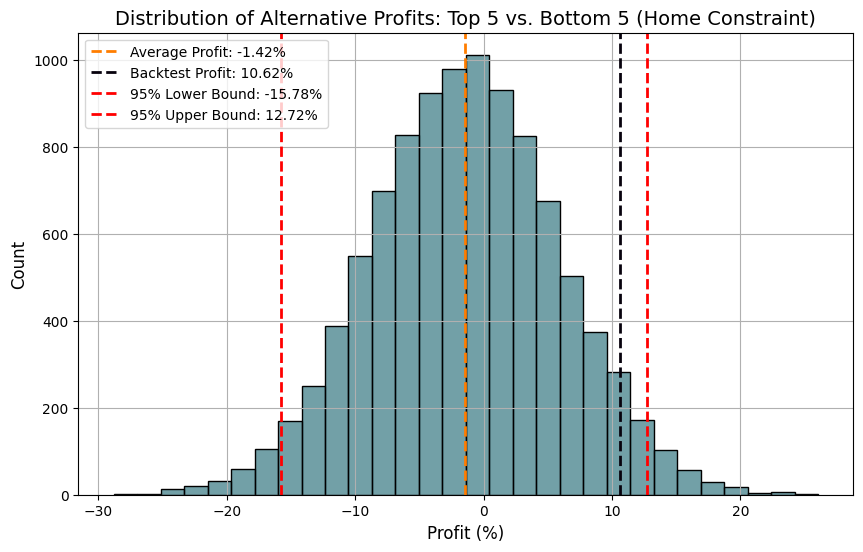


Summary of random effect analysis
  Average profit over simulations: -1.42%
  95% interval of profit: [-15.78%, 12.72%]
  Probability of ending better off than in the backtest: 5.00%
  Probability of ending with a loss: 57.62%
  Probability of ending better off than safe investment: 5.83%

Top 5 vs. Bottom 5 when Top plays at home: Average odds
Season-specific results
╒══════════╤═══════════════╤═══════════════════╤════════════════╤══════════════════╤════════╤══════════════╕
│  Season  │  Bets Placed  │  Successful Bets  │  Sharpness CI  │  Sharpness Mean  │  RBEP  │  Profit (%)  │
╞══════════╪═══════════════╪═══════════════════╪════════════════╪══════════════════╪════════╪══════════════╡
│   2019   │      21       │        19         │ [0.724, 0.977] │       0.87       │  0.75  │     25.1     │
├──────────┼───────────────┼───────────────────┼────────────────┼──────────────────┼────────┼──────────────┤
│   2020   │      24       │        15         │ [0.427, 0.789] │       0.62       

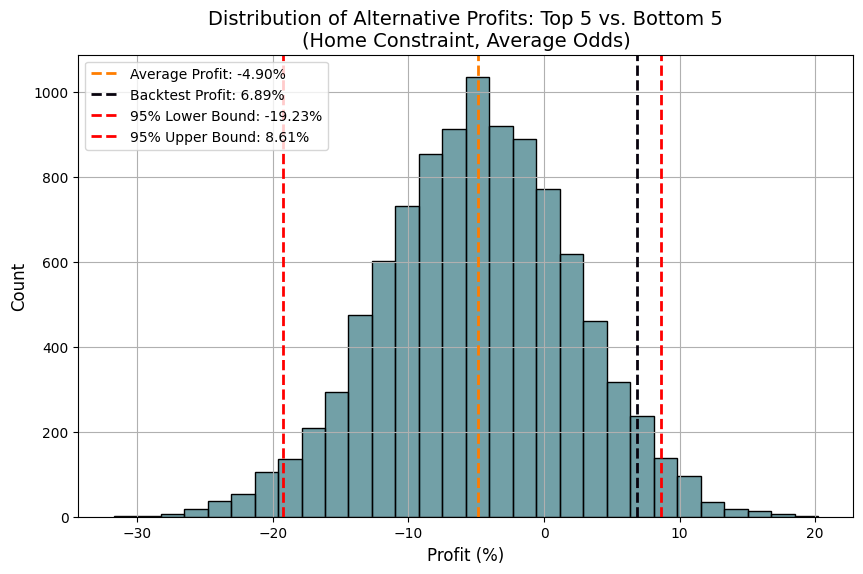


Summary of random effect analysis
  Average profit over simulations: -4.90%
  95% interval of profit: [-19.23%, 8.61%]
  Probability of ending better off than in the backtest: 4.51%
  Probability of ending with a loss: 75.45%
  Probability of ending better off than safe investment: 1.55%


In [8]:
print('\nTop 5 vs. Bottom 5 when Top plays at home: Optimized odds')
posterior_leaderboard_5v5_home = run_constrained_leaderboard_bet(df, seasons, top_x = 5, bottom_y = 5, plot_title = "Top 5 vs. Bottom 5 (Home Constraint)", analysis_type = 'Full', home_constraint = True, odds_picking = True)
print('\nTop 5 vs. Bottom 5 when Top plays at home: Average odds')
posterior_leaderboard_5v5_home = run_constrained_leaderboard_bet(df, seasons, top_x = 5, bottom_y = 5, plot_title = "Top 5 vs. Bottom 5\n(Home Constraint, Average Odds)", analysis_type = 'Full', home_constraint = True, odds_picking = False)